# <font color='#4C6FF3'>Regularized Regression</font>

#### <font color='#FF8253'>Conclusion: Best models trained on non-normalized data</font>

In [1]:
# Suppress runtime warnings
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
%matplotlib inline
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.sql import select
from fbprophet import Prophet

In [2]:
db_uri = 'mysql+pymysql://<user_name>@<EC2 DNS>'                                 

engine = create_engine(db_uri)                                                                                                                    
meta = MetaData()                                                           
meta.reflect(bind=engine)                                                   
conn = engine.connect()

In [3]:
bpi  = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)     # Bitcoin Price Index
mng  = pd.read_sql('''SELECT * FROM qdl_mining_data''', conn) # Quandl Mining Data
qmkt = pd.read_sql('''SELECT * FROM qdl_mkt_data''', conn)    # Quandl Market Data

In [5]:
bpi.date            = pd.to_datetime(bpi.date)
bpi.btc_usd_rate    = pd.to_numeric(bpi.btc_usd_rate)
mng.tot_blkchn_size = pd.to_numeric(mng.tot_blkchn_size)
mng.avg_blk_size    = pd.to_numeric(mng.avg_blk_size)
mng.tot_output_vol  = pd.to_numeric(mng.tot_output_vol)
mng.hash_rate_btc   = pd.to_numeric(mng.hash_rate_btc)
mng.miners_rev      = pd.to_numeric(mng.miners_rev)
mng.difficulty      = pd.to_numeric(mng.difficulty)
mng.date            = pd.to_datetime(mng.date)

qmkt.date                 = pd.to_datetime(qmkt.date)
qmkt.tot_BTCs             = pd.to_numeric(qmkt.tot_BTCs)
qmkt.btc_mkt_cap          = pd.to_numeric(qmkt.btc_mkt_cap)
qmkt.tot_btc_addrs        = pd.to_numeric(qmkt.tot_btc_addrs)
qmkt.btc_trans_vol        = pd.to_numeric(qmkt.btc_trans_vol)
qmkt.btc_exch_trade_vol   = pd.to_numeric(qmkt.btc_exch_trade_vol)
qmkt.btc_num_trans        = pd.to_numeric(qmkt.btc_num_trans)
qmkt.btc_tot_trans        = pd.to_numeric(qmkt.btc_tot_trans)
qmkt.trans_less_pop_addrs = pd.to_numeric(qmkt.trans_less_pop_addrs)
qmkt.trans_per_blk        = pd.to_numeric(qmkt.trans_per_blk)
qmkt.avg_trans_conf_time  = pd.to_numeric(qmkt.avg_trans_conf_time)
qmkt.tot_trans_fees_btc   = pd.to_numeric(qmkt.tot_trans_fees_btc)
qmkt.tot_trans_fees_usd   = pd.to_numeric(qmkt.tot_trans_fees_usd)
qmkt.cost_per_trans       = pd.to_numeric(qmkt.cost_per_trans)
qmkt.cost_as_perct_vol    = pd.to_numeric(qmkt.cost_as_perct_vol)

In [6]:
dfs = [bpi, mng, qmkt]
df = reduce(lambda df1, df2: pd.merge(df1, df2, on='date'), dfs)

In [8]:
y = df.btc_usd_rate

X = df[[col for col in list(df.columns) if not col == 'residuals'\
                                        and not col == 'btc_usd_rate'\
                                        and not col == 'date'\
                                        and not col == 'timestp']]

In [11]:
# Split data into train and test sets
train_size = int(len(X) * 0.66)

y_train, y_test = y[1:train_size], y[train_size:]
X_train, X_test = X[1:train_size], X[train_size:]

### <font color='#52B26C'> *Without* Normalization</font>

In [13]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [32]:
# Fit estimators
ESTIMATORS = {'LinReg' : LinearRegression(),
              'Ridge'  : Ridge(),
              'Lasso'  : Lasso(),
              'LassoCV': LassoCV(), 
              'RndFrst': RandomForestRegressor(n_estimators=150, min_samples_split=2)}

predictions    = dict()
r2_scores      = dict()

for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    predictions[name]    = estimator.predict(X_test)
    r2_scores[name]      = estimator.score(X_test, y_test)

In [40]:
r2s = pd.DataFrame(r2_scores.items(), columns=['Model', 'R-Squared'])
r2s

,Model,R-Squared
0,LinReg,0.803401
1,Ridge,0.786727
2,LassoCV,0.963718
3,RndFrst,0.756020
4,Lasso,0.814685


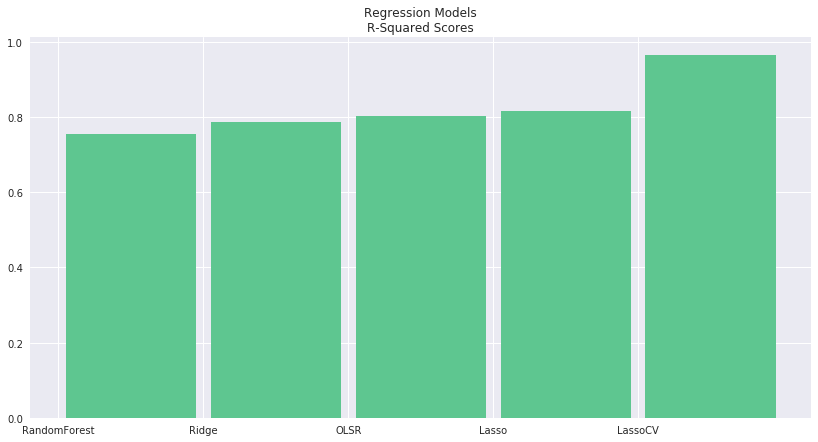

In [57]:
plt.figure(figsize=(14, 7))
xlocations = np.array(range(len(r2_scores))) + 0.5
y_pos = np.arange(len(r2_scores))
plt.bar(xlocations, r2s['R-Squared'].order(), width=0.9, color='#5EC690')
# plt.xticks(y_pos, r2s['Model'])
plt.xticks(y_pos, ['RandomForest', 'Ridge', 'OLSR', 'Lasso', 'LassoCV'])
# plt.ylabel('R-Squared Scores')
plt.title('Regression Models\nR-Squared Scores');

### <font color='#52B26C'> *With* Normalization</font>

#### 1. Subtract the mean and divide by the standard deviation

In [11]:
Xn = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
Xn.head()

,googl_srchs,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,tot_BTCs,btc_mkt_cap,tot_btc_addrs,...,btc_exch_trade_vol,btc_num_trans,btc_tot_trans,trans_less_pop_addrs,trans_per_blk,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol
0,-1.253728,-1.161775,-1.123040,-0.152435,-0.771314,-1.619669,-0.770154,-1.830274,-1.435246,-1.377759,...,-0.689841,-1.076046,-1.204892,-1.204054,-0.805119,0.077467,-0.113350,-0.516013,-0.986018,0.080503
1,-1.253728,-1.157365,-0.934056,-0.197332,-0.771316,-1.624800,-0.770152,-1.816243,-1.433217,-1.423840,...,-0.685996,-1.036489,-1.199061,-1.292255,-0.791944,1.277844,-0.095358,-0.515142,-0.994723,-0.175244
2,-1.253728,-1.152722,-1.004387,-0.110223,-0.771314,-1.614470,-0.770152,-1.802625,-1.426282,-1.422791,...,-0.658187,-1.069357,-1.192978,-1.243804,-0.874755,0.484612,-0.224963,-0.514836,-0.977946,-0.354108
3,-1.184818,-1.147980,-0.942902,-0.086513,-0.771313,-1.595354,-0.770154,-1.787947,-1.422411,-1.355637,...,-0.668461,-0.921788,-1.186820,-1.238500,-0.857817,0.196803,0.096748,-0.508416,-0.991186,-0.427877
4,-1.184818,-1.142674,-0.944148,-0.007800,-0.771311,-1.574755,-0.770154,-1.771399,-1.415598,-1.360373,...,-0.658350,-0.852352,-1.180039,-1.207652,-0.842760,0.224882,0.222213,-0.503375,-0.969806,-0.020001


In [18]:
yn = (y - np.mean(y)) / np.std(y)
yn.head()

0   -1.529451
1   -1.527006
2   -1.521155
3   -1.513332
4   -1.503095
Name: btc_usd_rate, dtype: float64

In [19]:
# Split data into train and test sets
train_size = int(len(Xn) * 0.66)

y_train, y_test = yn[1:train_size], yn[train_size:]
X_train, X_test = Xn[1:train_size], Xn[train_size:]

In [22]:
# Fit estimators
ESTIMATORS = {'LinReg' : LinearRegression(),
              'Ridge'  : Ridge(),
              'Lasso'  : Lasso(),
              'LassoCV': LassoCV()}

predictions    = dict()
r2_scores      = dict()

for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    predictions[name]    = estimator.predict(X_test)
    r2_scores[name]      = estimator.score(X_test, y_test)

In [23]:
r2_scores

{'Lasso': -1.5616525561313694,
 'LassoCV': 0.94411123019853005,
 'LinReg': 0.77664150932440945,
 'Ridge': 0.60646852699639386}

#### 2. Log

In [13]:
Xl = X.apply(lambda x: np.log(x))
Xl.head()

,googl_srchs,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,tot_BTCs,btc_mkt_cap,tot_btc_addrs,...,btc_exch_trade_vol,btc_num_trans,btc_tot_trans,trans_less_pop_addrs,trans_per_blk,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol
0,1.386294,8.323366,-2.301479,13.867695,3.046085,10.789980,14.907312,16.179753,18.785424,10.577274,...,12.374717,10.617907,16.198716,9.803170,5.973810,2.136137,3.549693,6.154972,0.332352,0.923996
1,1.386294,8.355145,-1.882043,13.749844,2.980994,10.695601,14.994027,16.181990,18.842611,10.396170,...,12.681828,10.687366,16.228012,9.347665,5.991465,2.426277,3.568854,6.229114,0.237772,0.773938
2,1.386294,8.387540,-2.018428,13.967108,3.059775,10.877318,14.994027,16.184157,19.016535,10.400681,...,13.750703,10.629997,16.257689,9.622980,5.874931,2.244250,3.421853,6.253889,0.412707,0.653766
3,1.609438,8.419580,-1.898209,14.018897,3.110486,11.145420,14.903660,16.186488,19.101898,10.653795,...,13.472856,10.865153,16.286856,9.648982,5.899897,2.169054,3.753367,6.668431,0.277287,0.599665
4,1.609438,8.454253,-1.900508,14.173808,3.192551,11.371292,14.903660,16.189108,19.236419,10.637897,...,13.746846,10.959192,16.318026,9.788133,5.921578,2.176644,3.857765,6.904665,0.487693,0.867681


In [27]:
yl = np.log(y)

In [28]:
# Split data into train and test sets
train_size = int(len(Xn) * 0.66)

y_train, y_test = yl[1:train_size], yl[train_size:]
X_train, X_test = Xl[1:train_size], Xl[train_size:]

In [29]:
# Fit estimators
ESTIMATORS = {'LinReg' : LinearRegression(),
              'Ridge'  : Ridge(),
              'Lasso'  : Lasso(),
              'LassoCV': LassoCV()}

predictions    = dict()
r2_scores      = dict()

for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    predictions[name]    = estimator.predict(X_test)
    r2_scores[name]      = estimator.score(X_test, y_test)

In [30]:
r2_scores



{'Lasso': -1.327126102139276,
 'LassoCV': 0.97358505316993027,
 'LinReg': -0.50129048722342118,
 'Ridge': 0.61902525472334857}

In [1]:
import datetime
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
%matplotlib inline
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.sql import select
from fbprophet import Prophet


In [54]:
def get_regr_models():
    '''
    Train and return OLSR, Ridge, Lasso, LassoCV
    '''
    db_uri = '<user_pass>@<EC2 DNS>'                                 

    engine = create_engine(db_uri)                                                                                                                    
    meta = MetaData()                                                           
    meta.reflect(bind=engine)                                                   
    conn = engine.connect()
    
    bpi  = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)     # Bitcoin Price Index
    mng  = pd.read_sql('''SELECT * FROM qdl_mining_data''', conn) # Quandl Mining Data
    qmkt = pd.read_sql('''SELECT * FROM qdl_mkt_data''', conn)    # Quandl Market Data
    
    bpi.date            = pd.to_datetime(bpi.date)
    bpi.btc_usd_rate    = pd.to_numeric(bpi.btc_usd_rate)
    mng.tot_blkchn_size = pd.to_numeric(mng.tot_blkchn_size)
    mng.avg_blk_size    = pd.to_numeric(mng.avg_blk_size)
    mng.tot_output_vol  = pd.to_numeric(mng.tot_output_vol)
    mng.hash_rate_btc   = pd.to_numeric(mng.hash_rate_btc)
    mng.miners_rev      = pd.to_numeric(mng.miners_rev)
    mng.difficulty      = pd.to_numeric(mng.difficulty)
    mng.date            = pd.to_datetime(mng.date)
    qmkt.date                 = pd.to_datetime(qmkt.date)
    qmkt.tot_BTCs             = pd.to_numeric(qmkt.tot_BTCs)
    qmkt.btc_mkt_cap          = pd.to_numeric(qmkt.btc_mkt_cap)
    qmkt.tot_btc_addrs        = pd.to_numeric(qmkt.tot_btc_addrs)
    qmkt.btc_trans_vol        = pd.to_numeric(qmkt.btc_trans_vol)
    qmkt.btc_exch_trade_vol   = pd.to_numeric(qmkt.btc_exch_trade_vol)
    qmkt.btc_num_trans        = pd.to_numeric(qmkt.btc_num_trans)
    qmkt.btc_tot_trans        = pd.to_numeric(qmkt.btc_tot_trans)
    qmkt.trans_less_pop_addrs = pd.to_numeric(qmkt.trans_less_pop_addrs)
    qmkt.trans_per_blk        = pd.to_numeric(qmkt.trans_per_blk)
    qmkt.avg_trans_conf_time  = pd.to_numeric(qmkt.avg_trans_conf_time)
    qmkt.tot_trans_fees_btc   = pd.to_numeric(qmkt.tot_trans_fees_btc)
    qmkt.tot_trans_fees_usd   = pd.to_numeric(qmkt.tot_trans_fees_usd)
    qmkt.cost_per_trans       = pd.to_numeric(qmkt.cost_per_trans)
    qmkt.cost_as_perct_vol    = pd.to_numeric(qmkt.cost_as_perct_vol)

    dfs = [bpi, mng, qmkt]
    df = reduce(lambda df1, df2: pd.merge(df1, df2, on='date'), dfs)
    
    # Extract predictor variables from yesterday
    # NOTE: This may need to be adjusted ('days=1' if running in AM, 'days=2' if PM)
    yester_data = df[df.date == (datetime.date.today() - datetime.timedelta(days=2))]
    yester_data = yester_data[[col for col in list(yester_data.columns) if not col == 'date'\
                                                                        and not col == 'timestp'\
                                                                        and not col == 'residuals'\
                                                                        and not col == 'btc_usd_rate']]
    
    # Create DataFrame on which to train the model
    df = df[df.date < (datetime.date.today() - datetime.timedelta(days=1))]
    
    # Create target and predictors
    y = df.btc_usd_rate
    X = df[[col for col in list(df.columns) if not col == 'residuals'\
                                            and not col == 'btc_usd_rate'\
                                            and not col == 'date'\
                                            and not col == 'timestp']]
        
    # Split data into train and test sets
    train_size = int(len(X) * 0.66)
    y_train, y_test = y[1:train_size], y[train_size:]
    X_train, X_test = X[1:train_size], X[train_size:]
    
    # Fit estimators
    olsr = LinearRegression()
    rdge = Ridge()
    lsso = Lasso()
    lscv = LassoCV()
    
    olsr.fit(X_train, y_train)
    rdge.fit(X_train, y_train)
    lsso.fit(X_train, y_train)
    lscv.fit(X_train, y_train)
    
    predictions = dict()
    r2_scores   = dict()
    
    predictions['OLSR'] = olsr.predict(X_test)
    predictions['RDGE'] = rdge.predict(X_test)
    predictions['LSSO'] = lsso.predict(X_test)
    predictions['LSCV'] = lscv.predict(X_test)
    
    r2_scores['OLSR'] = olsr.score(X_test, y_test)
    r2_scores['RDGE'] = rdge.score(X_test, y_test)
    r2_scores['LSSO'] = lsso.score(X_test, y_test)
    r2_scores['LSCV'] = lscv.score(X_test, y_test)
    
    return olsr, rdge, lsso, lscv, yester_data, training_predictions, r2_scores 

In [55]:
olsr, rdge, lsso, lscv, yester_data, predictions, r2_scores = get_regr_models()


In [56]:
olsr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
rdge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
lsso

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
lscv

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [60]:
yester_data.head()

,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,tot_BTCs,btc_mkt_cap,tot_btc_addrs,btc_trans_vol,btc_exch_trade_vol,btc_num_trans,btc_tot_trans,trans_less_pop_addrs,trans_per_blk,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol
1560,111096.468465,0.991744,1.615445e+06,3.909321e+06,2416965.0,5.208087e+11,16275762.5,1.949836e+10,520821,231541.159316,2.154701e+07,271976,213740161,267026,1801.165563,16.1,202.572395,242681.729605,9.206352,0.902679


In [65]:
float(olsr.predict(yester_data))

1405.5689234830036

In [62]:
rdge.predict(yester_data)

array([ 1416.5076169])

In [63]:
lsso.predict(yester_data)

array([ 1384.25885155])

In [64]:
lscv.predict(yester_data)

array([ 1109.16178503])